In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.float_format = '{:.2f}'.format #Setting changed for better visibility purposes
sns.set()

In [2]:
filename = '/Users/agm/Desktop/Capstone2/Data/2018_9_reduced.csv'
df = pd.read_csv(filename)

In [3]:
#Reviewing summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
activity_year,8393516.00,2018.50,0.50,2018.00,2018.00,2019.00,2019.00,2019.00
county_code,8393516.00,27982.19,16474.94,1001.00,12101.00,27053.00,42091.00,72153.00
census_tract,8393516.00,27982400309.52,16474955468.25,1001020100.00,12101031805.00,27053026022.00,42091201705.00,72153750602.00
action_taken,8393516.00,1.20,0.57,1.00,1.00,1.00,1.00,3.00
loan_type,8393516.00,1.45,0.76,1.00,1.00,1.00,2.00,4.00
loan_amount,8393516.00,278432.19,241297.06,5000.00,155000.00,225000.00,335000.00,98005000.00
loan_to_value_ratio,8393516.00,100.94,16991.71,0.00,80.00,91.70,96.50,35196000.00
loan_term,8393516.00,348.98,91.70,1.00,360.00,360.00,360.00,216000.00
property_value,8393516.00,352263.20,2543713.17,5000.00,175000.00,265000.00,395000.00,2147483647.00
occupancy_type,8393516.00,1.10,0.38,1.00,1.00,1.00,1.00,3.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8393516 entries, 0 to 8393515
Data columns (total 24 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   activity_year                      int64  
 1   lei                                object 
 2   state_code                         object 
 3   county_code                        float64
 4   census_tract                       int64  
 5   conforming_loan_limit              object 
 6   action_taken                       int64  
 7   loan_type                          int64  
 8   loan_amount                        float64
 9   loan_to_value_ratio                float64
 10  loan_term                          int64  
 11  property_value                     int64  
 12  occupancy_type                     int64  
 13  total_units                        int64  
 14  income                             float64
 15  debt_to_income_ratio               object 
 16  applicant_ethnicit

In [8]:
#Value counts for each column

for column in df.columns:
    print(column)
    print(df[column].value_counts().sort_values(),'\n')

activity_year
2018    4155822
2019    4237694
Name: activity_year, dtype: int64 

lei
254900JSR03JVTTZ6039         1
2549008TF4FG4ON44F19         1
254900FE6QJXGH3VIA90         1
5493001BJFQ0EM41N379         1
549300HXEGS61WUUIM55         1
                         ...  
549300J7XKT2BI5WX213    176939
549300MGPZBLQDIL7538    195192
549300HW662MN1WU8550    283409
KB1H1DSPRFMYMCUFXT09    286361
549300FGXN1K3HLB1R50    333786
Name: lei, Length: 3386, dtype: int64 

state_code
GU       133
VT     14415
WY     14976
AK     15227
ND     16617
DC     17119
SD     20170
PR     23073
RI     26551
HI     26598
MT     28129
DE     31621
WV     32178
ME     33973
NH     40878
NE     43495
NM     47905
MS     55235
KS     66200
AR     71159
ID     73902
IA     79107
CT     79755
OK     89192
LA     91045
KY    101809
NV    111376
UT    120894
AL    123387
OR    125448
WI    144161
MA    152008
MO    157458
MN    159702
MD    170724
SC    175752
IN    194411
TN    196505
NJ    206087
CO    220371
WA

The summary statistics allow presenting a general summary of the features and identifying further actions:

1. activity_year: Can only be 2018 or 2019. Currently an int.

2. LEI: Contains 3386 IDs for mortgage providers. Currently an object.

3. state_code: Contains 53 labels for states. Currently an object.

4. county_code: Contains 3217 IDs for counties. Currently a float.

5. census_tract: Contains 72468 IDs for tracts. Currently an int.

6. conforming_loan_limit: Can only be 'C' or 'NC'. Currently an object; will be changed to 0/1.

7. action_taken: Can only be 1, 2, or 3. Currently an int. Will be changed to 0/1 from 1 - Loan originated, 2 - Application approved but not accepted, and 3 - Application denied.

8. loan_type: Can only be 1, 2, 3, or 4. Currently an int.

9. loan_amount: Contains outliers; how these will be handled, if at all, is TBD. Int64.

10. loan_to_value_ratio: Int64.

11. loan_term: Corresponds to month amount; Int64. Contains error values (e.g. 8888, 3630). Further investigation is warranted.

12. property_value: Contains outliers; how these will be handled, if at all, is TBD. Int64.

13. occupancy_type: Can only be 1, 2, or 3. Currently an int.

14. total_units: Four types. Currently an int.

15. income: Contains outliers that are likely erroneous or extreme; income is expressed in thousands of dollars (e.g. negative incomes). To be investigated further. 

16. debt_to_income_ratio: Binned values that limit universe to 19 categories. Currently an object.

17. applicant_ethnicity-1: Eight floats that correspond to a category. Currently a float.

18. applicant_race-1: Eighteen floats that correspond to a category. Currently a float.

19. applicant_sex: Five integers that correspond to a category; three error categories will be handled. Currently an int.

20. applicant_age: Seven binned categories. Currently an int.

21. submission_of_application: Four possible values. Two are error categories, which will be handled.

22. tract_minority_population_percent: Census-related data, int64.

23. ffiec_msa_md_median_family_income: Census-related data, int64.

24. tract_to_msa_income_percentage: Census-related data, int64.


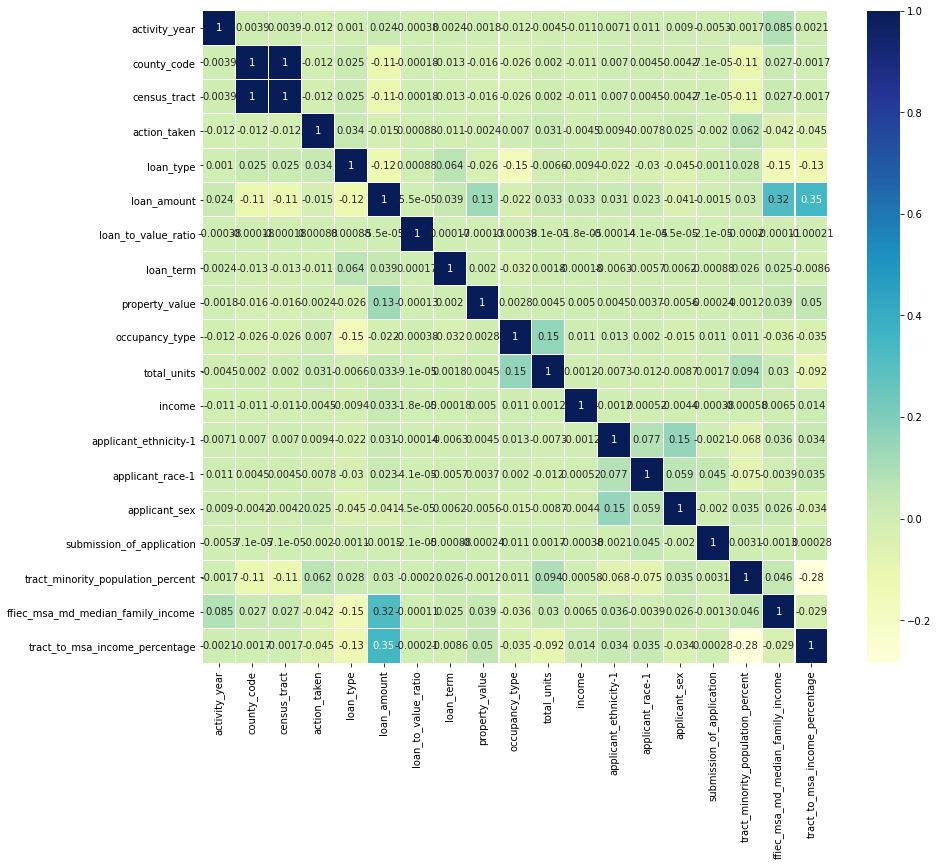

In [12]:
#Heatmap
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

The correlation heatmap suggests there is no one feature that is strongly correlated with our target variable, action_taken. The strongest correlations are between loan_amount and tract_to_msa_income_percentage and ffiec_msa_md_median_family_income, which are co-dependent on the tract number.

In [17]:
#The following section converts action_taken to a binary category: 0 if the loan application was rejected 
#and 1 if it was accepted.
df.action_taken = 1 * (df.action_taken < 3)

/Users/agm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


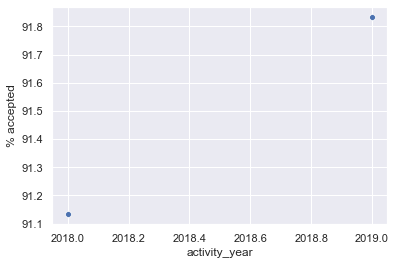

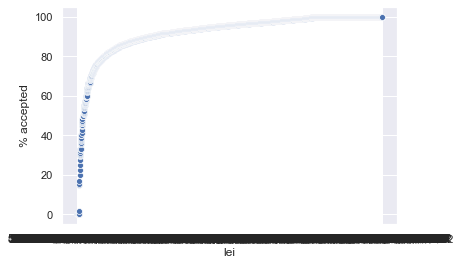

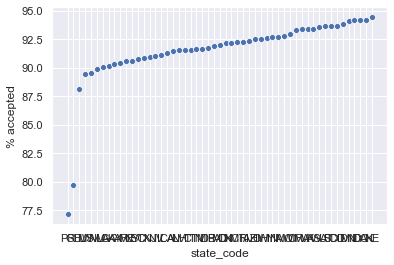

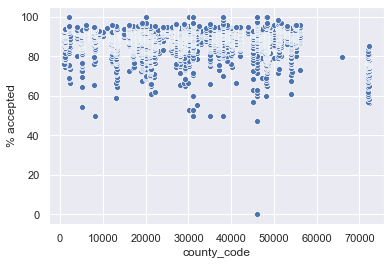

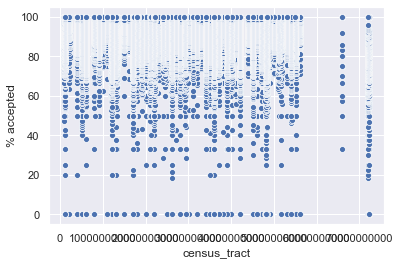

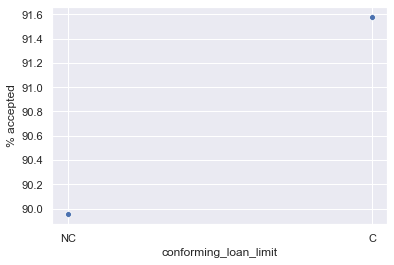

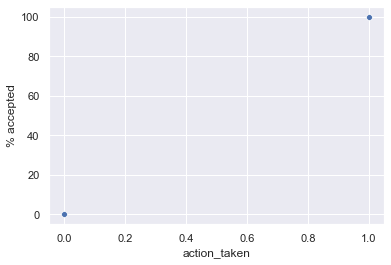

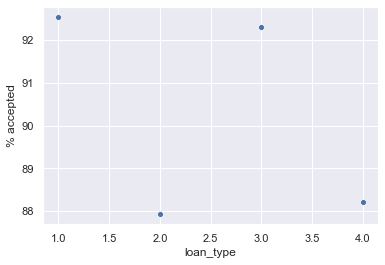

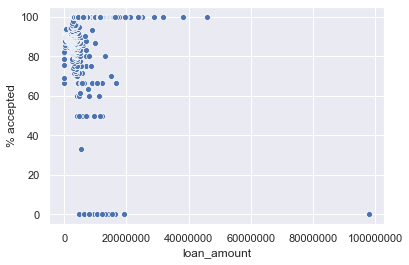

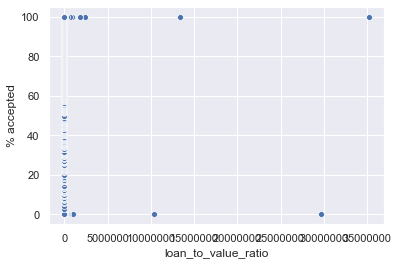

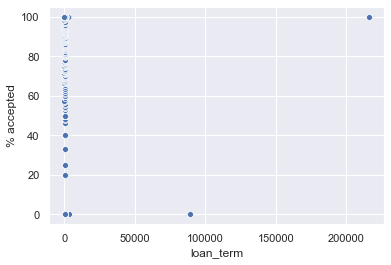

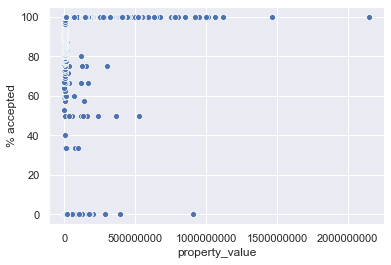

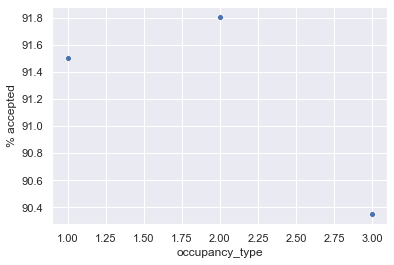

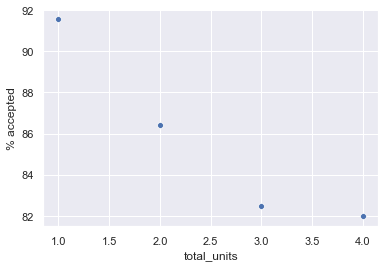

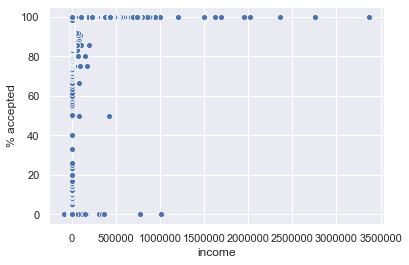

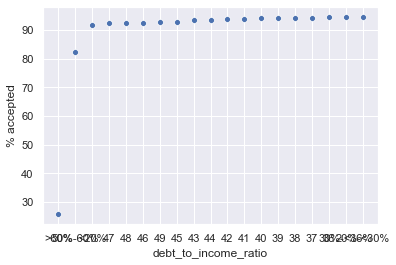

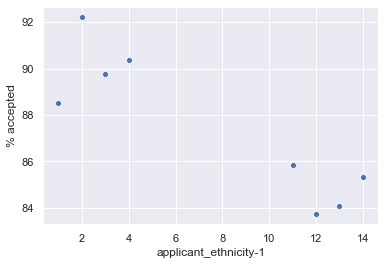

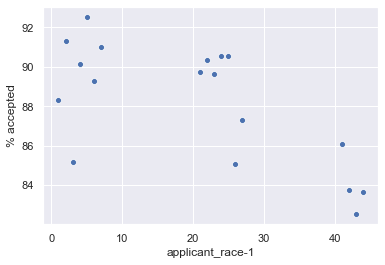

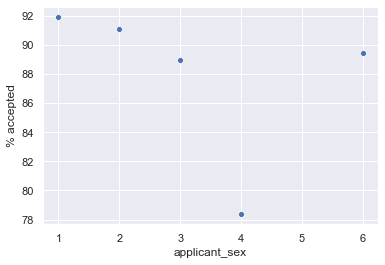

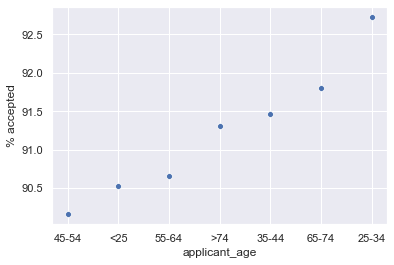

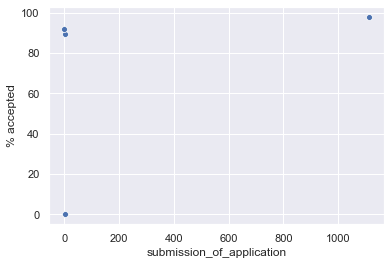

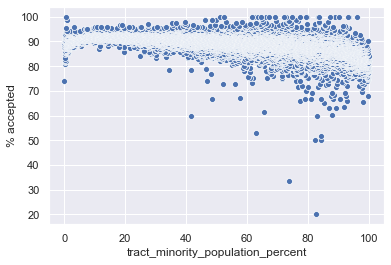

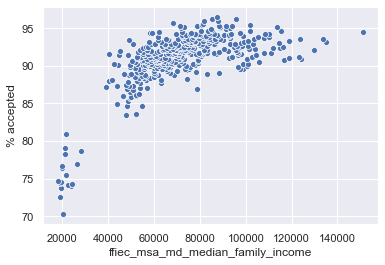

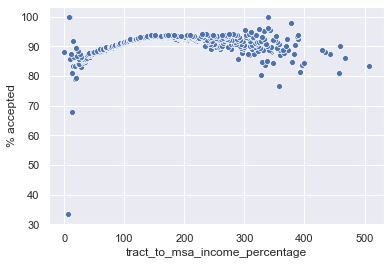

In [87]:
#For each feature, plot feature vs. outcome to determine if, a priori, there seem to be flagrant correlations
#df['action_taken'].groupby(df['applicant_age']).sum()/len()

def plot_feature_acceptance (feature):
    '''Plots a scatterplot of the acceptance rate of grouped features'''
    temp = df.groupby(feature)['action_taken'].agg([('% accepted', lambda x: x.sum() / x.count() * 100)]).sort_values(by='% accepted').reset_index()
    plt.figure()
    plt.ticklabel_format(style='plain')
    sns.scatterplot(x=feature,y='% accepted',data=temp)

for column in df.columns:
    plot_feature_acceptance(column)

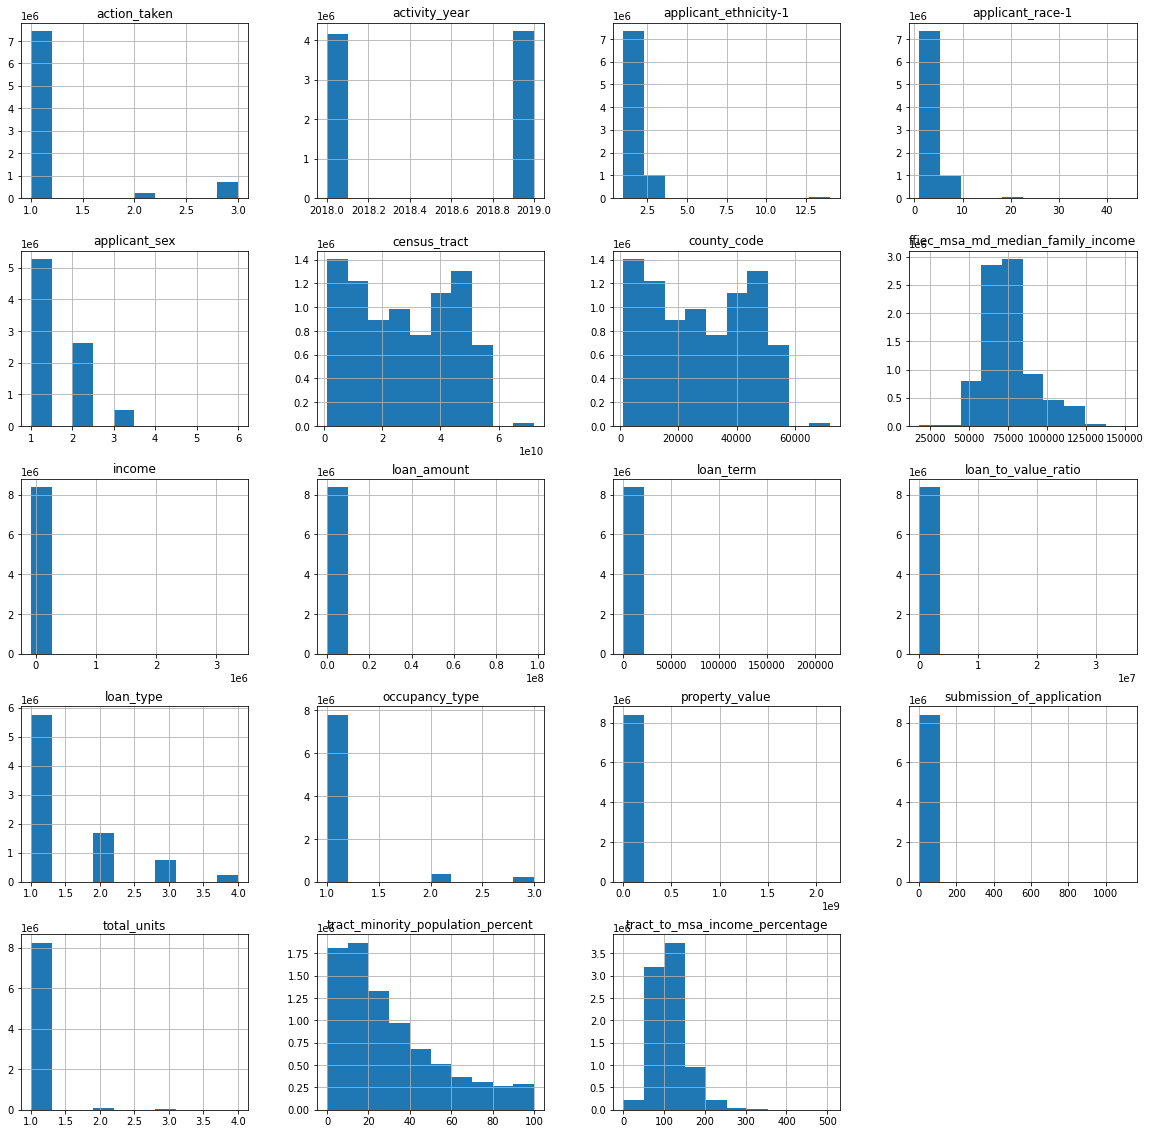

In [91]:
_ = df.hist(figsize=(20,20))

Categorical columns are explored below; LEI is ommitted, given that it is comprised of long string IDs for thousands of mortgage providers.

In [98]:
#select categorical variables only
df.select_dtypes(include = 'object').columns

Index(['lei', 'state_code', 'conforming_loan_limit', 'debt_to_income_ratio',
       'applicant_age'],
      dtype='object')

<AxesSubplot:>

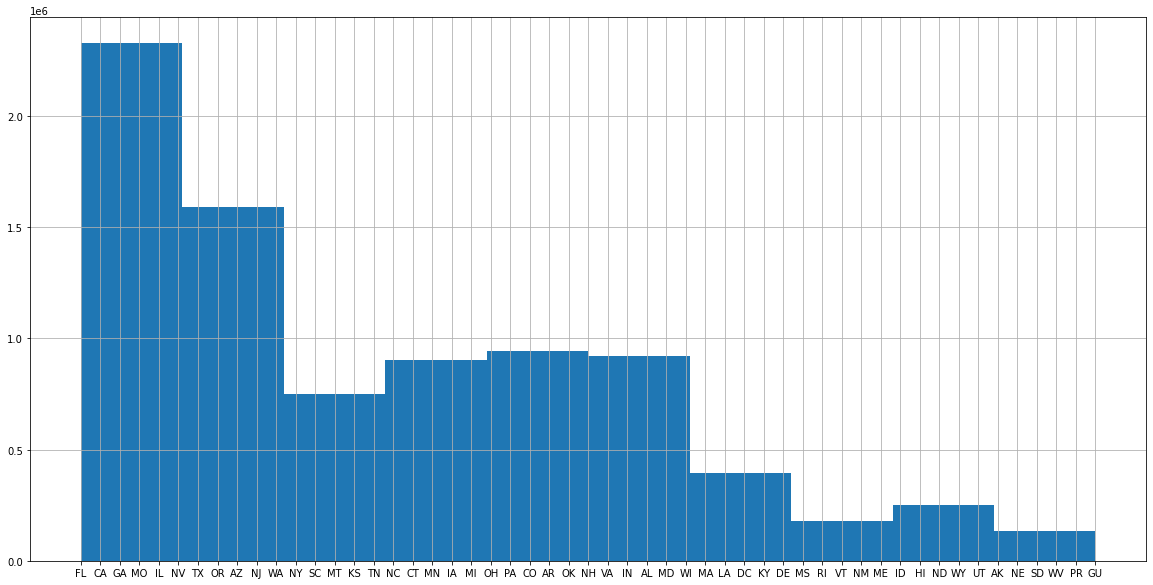

In [131]:
df.state_code.hist(figsize=(20,10))

<AxesSubplot:>

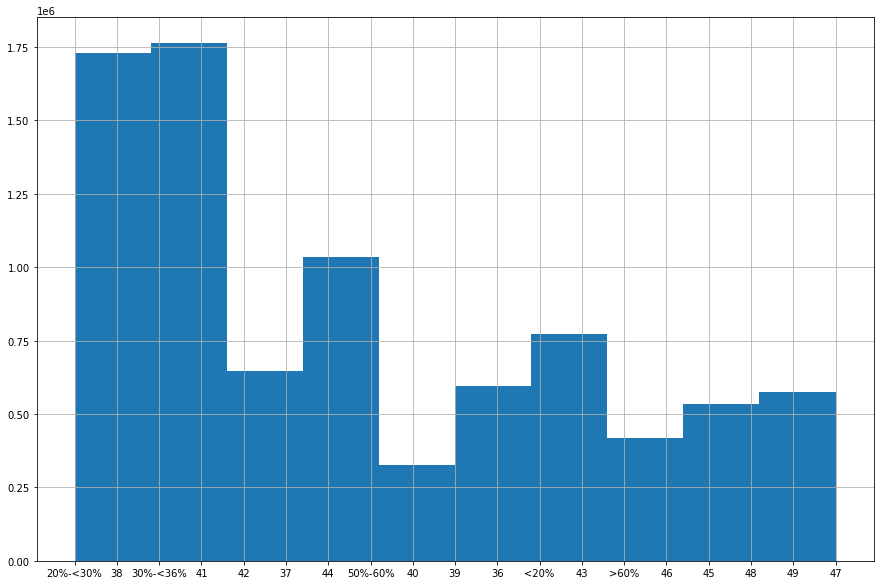

In [134]:
df.debt_to_income_ratio.hist(figsize=(15,10))

<AxesSubplot:>

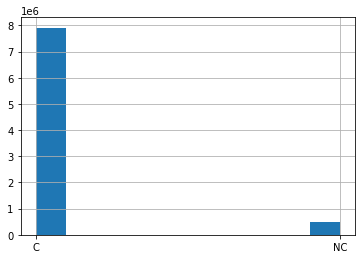

In [137]:
df.conforming_loan_limit.hist()

<AxesSubplot:>

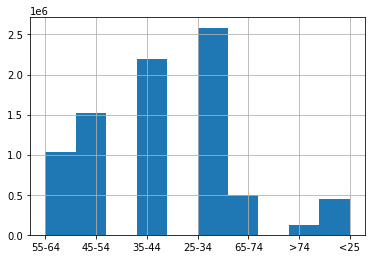

In [136]:
df.applicant_age.hist()

<AxesSubplot:>

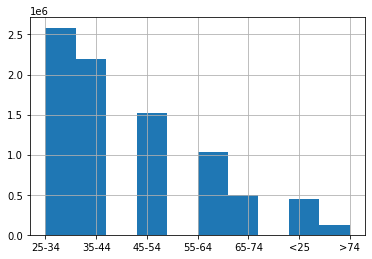

In [115]:
df.applicant_age.sort_values().hist()

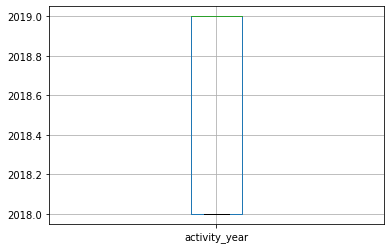

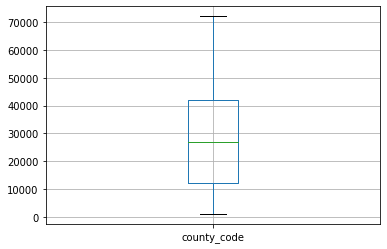

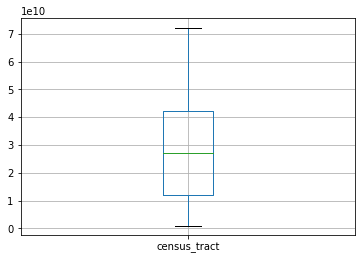

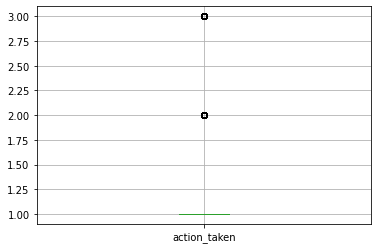

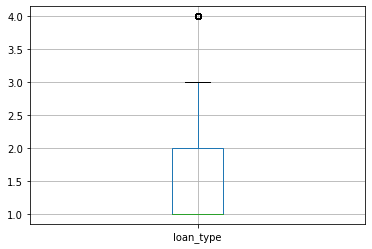

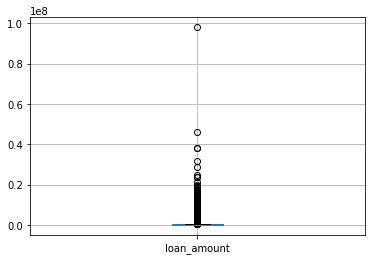

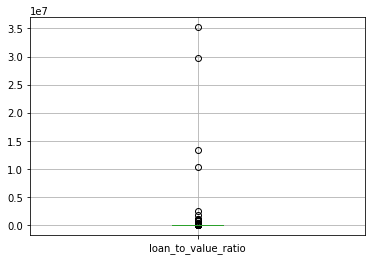

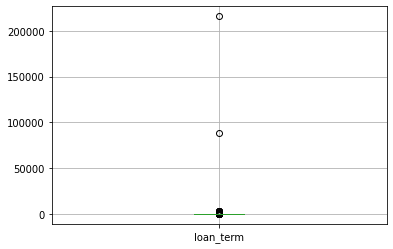

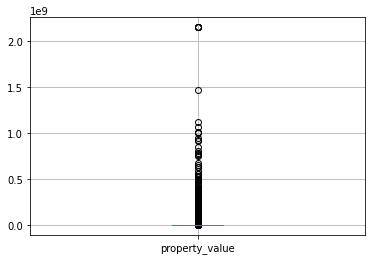

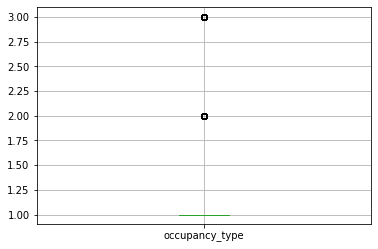

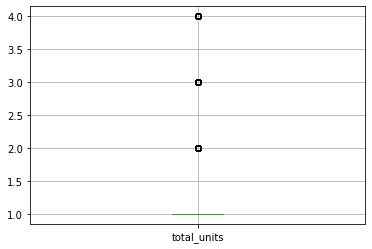

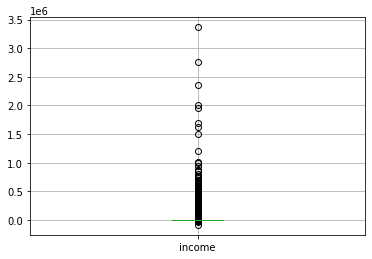

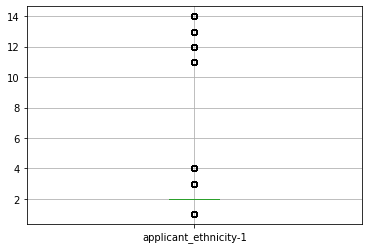

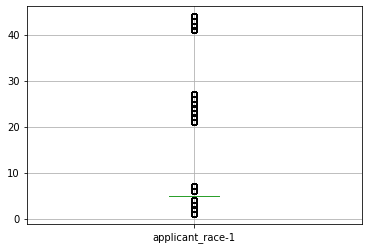

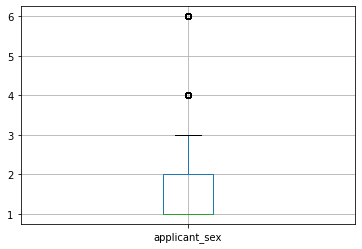

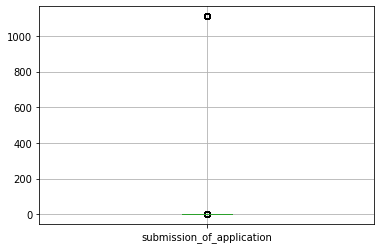

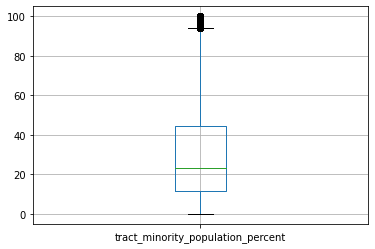

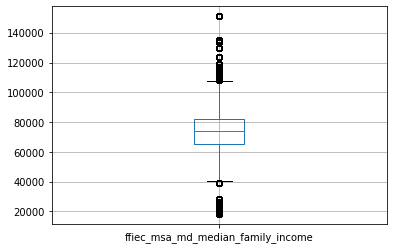

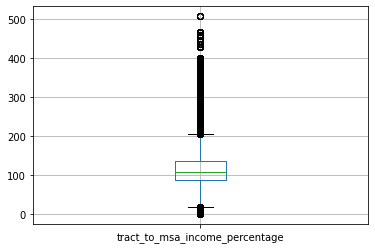

In [129]:
for column in df.select_dtypes(exclude = 'object'):
    plt.figure()
    df.boxplot([column])

The histograms and boxplots above suggest there are outliers in several columns (e.g. income, loan_amount, property_value).

Outliers and data types are handled as follows:

In [ ]:
_ = sns.pairplot(df) #Unable to execute; no results yielded after > one hour

The EDA above suggests the following three broad sets of actions:

1. Making decisions about categorical types in the feature engineering phase.
2. Making decisions about handling outliers that suggest error values.
3. Making decisions about sensitive features that suggest acceptance rate bias (e.g. race, ethnicity, state).